In [6]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches # drawing bounding box
from medpy.io import load as med_load
%matplotlib inline

from ipywidgets import interact

In [7]:
def parse_filepath(filepath):
    dirpath, filename = os.path.split(filepath)
    index = filename.split(".")[0].split("-")[-1]
    return dirpath, filename, index
    
def extract_one(filepath):
    img, img_header = med_load(filepath)
    dirpath, filename, index = parse_filepath(filepath)
    msk_filepath = os.path.join(dirpath, f"segmentation-{index}.nii")
    msk, _ = med_load(msk_filepath)
    
    offset = img_header.get_offset()  # tuple of 3
    direction = img_header.get_direction()  # (3, 3) array
    spacing = img_header.get_voxel_spacing()  # tuple of 3
    liver_ratio = np.sum(msk>=1)/np.product(img.shape)
    
    return img, msk, spacing, direction, offset, liver_ratio

def hu_clipping(img):
    img[img>250] = 250
    img[img<-200] = -200
    img = (img+200)/450
    return img

def get_filelist(dirpath):
    filelist = []
    for root, subdir, name_list in os.walk(dirpath):
        for filename in name_list:
            if filename.startswith("volume"):
                filelist.append(os.path.join(root, filename))
    return filelist

def find_liver_bbox(msk):
    """[OPT]
    msk.shape = (512, 512, num_z_slices)
    (x, y, z)

    mask description:
        0: background
        1: liver (not include tumor)
        2: tumor 
    
    
    """
    len_x, len_y, len_z = msk.shape
    index0 = np.sum(msk, axis=(1, 2)) > 0
    index1 = np.sum(msk, axis=(0, 2)) > 0
    index2 = np.sum(msk, axis=(0, 1)) > 0
    bbmin = np.zeros(3, dtype=int)
    bbmax = np.zeros(3, dtype=int)
    bbmin[0] = np.argmax(index0)
    bbmin[1] = np.argmax(index1)
    bbmin[2] = np.argmax(index2)
    bbmax[0] = len_x - np.argmax(index0[::-1])
    bbmax[1] = len_y - np.argmax(index1[::-1])
    bbmax[2] = len_z - np.argmax(index2[::-1])

    return bbmin, bbmax
    

In [8]:
def show_imgs(filepath, z, color='gray', liver_mask=True, tumor_mask=True, savefig=False, **kwargs):
    """
    
    """
    img, msk, spacing, direction, offset, liver_ratio = extract_one(filepath)
    new_img = hu_clipping(img)
    if direction[0, 0] == -1:
        new_img = new_img[::-1, ...]
        msk = msk[::-1, ...]
    if direction[1, 1] == -1:
        new_img = new_img[:, ::-1, ...]
        msk = msk[:, ::-1, ...]
    if direction[2, 2] == -1:
        new_img = new_img[..., ::-1]
        msk = msk[..., ::-1]
    # rotation 90 degree
    new_img = np.transpose(new_img, axes=(1, 0, 2))
    msk = np.transpose(msk, axes=(1, 0, 2))
    bbmin, bbmax = find_liver_bbox(msk)
    
    print(f" - Direction: {direction}, \n - Spacing: {spacing}, \n - offset: {offset}, \n - liver_ratio: {liver_ratio}")
    f, axes = plt.subplots(1,2, figsize=(30, 15))
    axes[0].axis("off")
    axes[1].axis("off")
    axes[0].imshow(new_img[:, :, z], cmap=color)
    axes[1].imshow(new_img[:, :, z], cmap=color)
    if liver_mask:
        axes[1].imshow(msk[:, :, z]==1, aspect='equal', cmap='Blues', alpha=0.3)
        rect = patches.Rectangle((bbmin[1], bbmin[0]), bbmax[1]-bbmin[1], bbmax[0]-bbmin[0], linewidth=3, edgecolor='r', facecolor='none')
        axes[1].add_patch(rect)
    if tumor_mask:
        axes[1].imshow(msk[:, :, z]==2, aspect='equal', cmap='Reds', alpha=0.4)
    if savefig:
        os.makedirs("./figures", exist_ok=True)
        plt.savefig("./figures/tempo.jpg")
        savefig = False
    plt.show()

In [9]:
filelist = sorted(get_filelist("./data"), key=lambda x: int(os.path.split(x)[-1].split(".")[0].split("-")[-1]))
#["./data/Training_Batch_1/volume-9.nii", "./data/Training_Batch_1/volume-10.nii", "./data/Training_Batch_1/volume-0.nii"]
CMAPS = ['viridis'] + sorted(m for m in plt.cm.datad if not m.endswith('_r'))

In [10]:
filelist

['./data/batch/volume-0.nii',
 './data/batch/volume-1.nii',
 './data/batch/volume-2.nii',
 './data/batch/volume-3.nii',
 './data/batch/volume-4.nii',
 './data/batch/volume-5.nii']

interactive(children=(Dropdown(description='filepath', options=('./data/batch/volume-0.nii', './data/batch/vol…

<function __main__.show_imgs(filepath, z, color='gray', liver_mask=True, tumor_mask=True, savefig=False, **kwargs)>

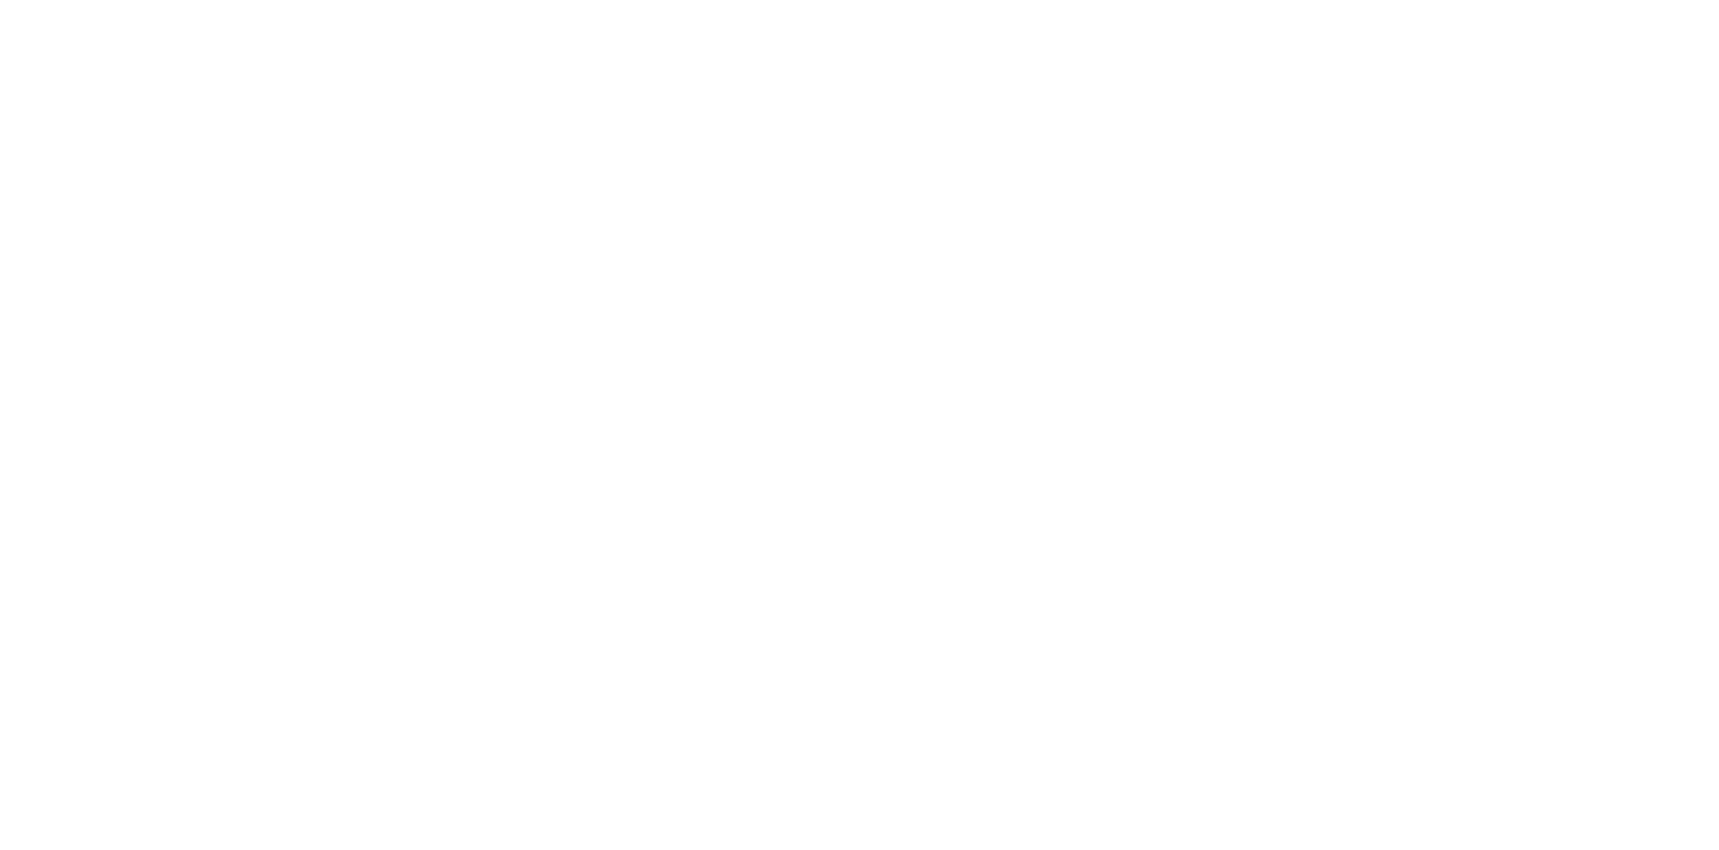

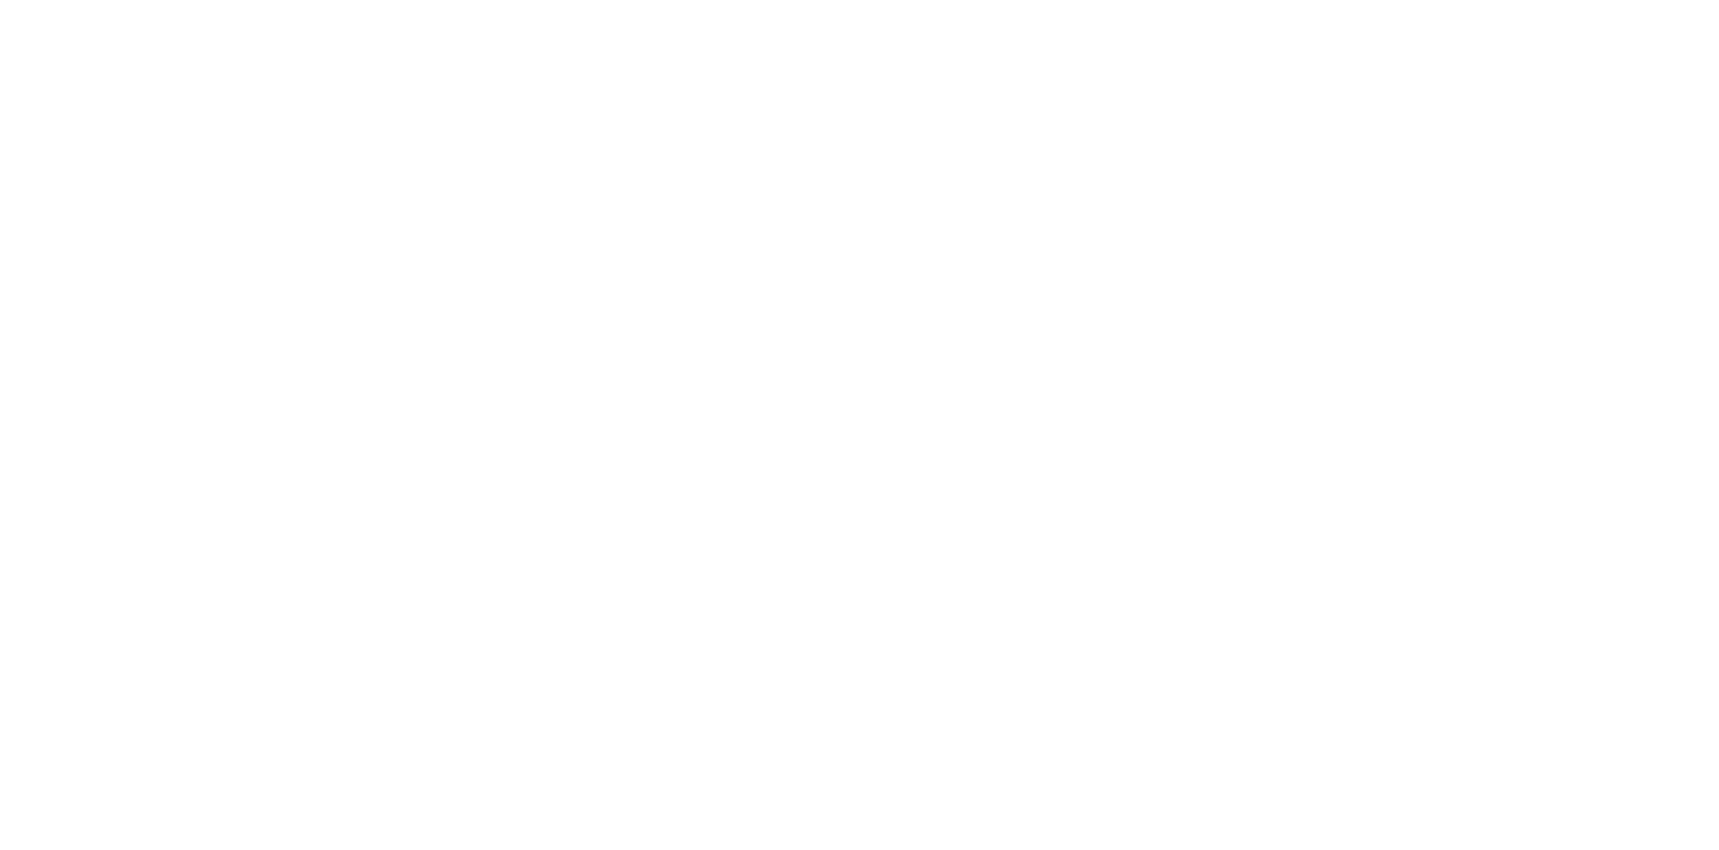

In [11]:
interact(show_imgs, filepath=filelist, z=(0, 500), color=CMAPS)

In [ ]:
# img, msk, spacing, direction, offset, liver_ratio = extract_one("./data/Training_Batch_1/volume-10.nii")